# Use of CODA on the VRE

## Example of CODA Atmospheric Toolbox use (S&T Corp)

> Abstract: Using pre-installed and configured CODA software to access data from original Aeolus products

## Load packages, modules and extensions

In [1]:
# enable following line for interactive visualization backend for matplotlib
# %matplotlib widget
# print version info
%load_ext watermark
%watermark -i -v -p viresclient,pandas,xarray,matplotlib

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.18.0

viresclient: 0.11.3
pandas     : 2.1.3
xarray     : 2023.12.0
matplotlib : 3.8.2



In [2]:
from viresclient import AeolusRequest

import os
import tarfile
import getpass
import fnmatch
from ftplib import FTP

import numpy as np
import matplotlib.pyplot as plt
# Configuration of CODA path not needed in VRE, might be required
# when using in other environments, example left here as reference
# os.putenv('CODA_DEFINITION', '/usr/share/coda/definitions/')

# Importing python bindings for coda, they are pre installed and available
import coda

## Atmospheric Toolbox CODA

CODA allows direct reading access to local product files, supporting a wide range of products among them support for Aeolus products.


Links of interest:
 - Main site: https://atmospherictoolbox.org/coda/
 - Documentation: http://stcorp.github.io/coda/doc/html/index.html
 - Github repository: https://github.com/stcorp/coda
 - Aeolus CODA definition: https://github.com/stcorp/codadef-aeolus
 

## Retrieval of original Aelous product

The easiest approach to access Aeolus data is through the use of the VirES service as explained thoroughly in most examples of the documentation.

If however you have a special case where you need to access Aeolus data in its original Earth Explorer format the VRE is pre-configured to allow the use of CODA. This means if you generated test files with custom processors you can upload them to your VRE workspace and work with them.

In order to show how to access information on products in the Aeolus format we fetch one example file from the ADDF. For your use case you can skip this step and use your own file uploaded to the workspace.

In [3]:
# Example file to fetch
filename = "AE_OPER_ALD_U_N_1B_20211126T091705022_005400014_018894_0001"

# Get user folder and set/create folder for example files
user_folder = os.path.expanduser("~")
example_folder = os.path.join(user_folder, "files/examples")
os.makedirs(example_folder, exist_ok=True)

# Check if file is already available
example_file_path_exists = False
for file in os.listdir(example_folder):
    if fnmatch.fnmatch(file, "*{}*.DBL".format(filename)):
        example_file_path = os.path.join(example_folder, file)
        example_file_path_exists = True

In [4]:
if not example_file_path_exists:
    # Set user and password from ESA SSO account
    USERNAME = os.environ["DATAU"]
    PW = os.environ["DATAP"]
    # Uncomment following two lines to provide your credentials as input
    # USERNAME = input("Please enter your SSO user name:")
    # PW = getpass.getpass("Please enter your password:")

    # Connect to the ADDF FTP server
    ftp = FTP("aeolus-ds.eo.esa.int")
    ftp.login(user=USERNAME, passwd=PW)

    # change directory
    ftp.cwd("/ADDF/L1B_preliminary_products/ALD_U_N_1B/1B12/2021-11/26/")

    # get file list of directory
    file_list = ftp.nlst()

    # check if example file is available and set file name
    try:
        example_filename = [k for k in file_list if filename in k][0]
    except:
        print("Warning: Example file not found")
        assert False

    # Download example file to user space
    example_file_packed_path = os.path.join(example_folder, example_filename)
    with open(example_file_packed_path, "wb") as fp:
        ftp.retrbinary("RETR " + example_filename, fp.write)

    # close FTP connection
    ftp.quit()

    # Open received compressed file
    tar = tarfile.open(example_file_packed_path, "r:gz")
    
    # Define file name for DBL-File
    example_file_name_unpacked = example_filename.split(".")[0] + ".DBL"

    # Extract only the .DBL file
    tar.extract(example_file_name_unpacked, path=example_folder)
    tar.close()
    
    # Define file path for extracted DBL-File
    example_file_path = os.path.join(example_folder, example_file_name_unpacked)

## Opening file with CODA
Now that we have retrieved (or uploaded the file) we can use the pre-configured CODA python bindings to open the Aeolus product and access the available parameters using their paths.


In [5]:
# Open coda file
pf = coda.open(example_file_path)

In [6]:
# Fetch specific parameter specifying the wanted path
rayleigh_wind_velocity = coda.fetch(
    pf, "wind_velocity", -1, "observation_wind_profile",
    "rayleigh_altitude_bin_wind_info", -1, "wind_velocity"
)

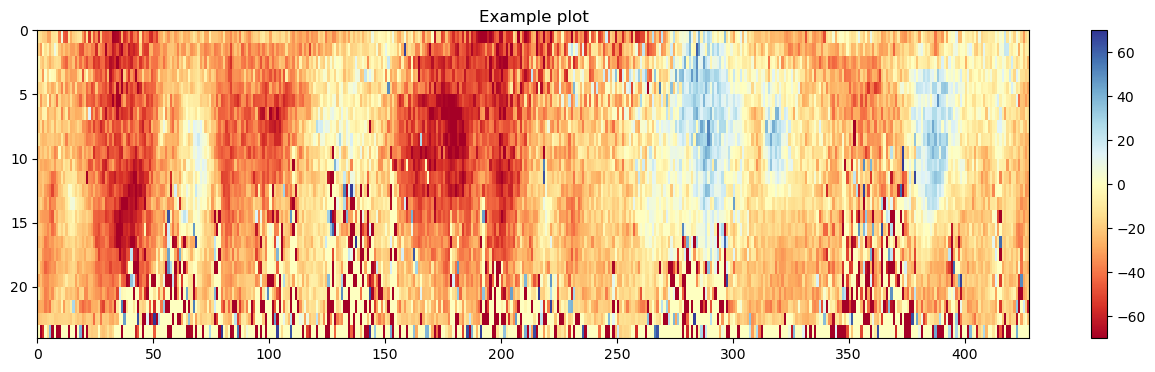

In [7]:
# Now that we have accessed the parameter data we can do a
# quick plot to visualize the content

# We transpose the array to better represent the data
transposed_data = np.vstack(rayleigh_wind_velocity).T

# We use a ver simple matplotlib example to plot the data
fig = plt.figure(figsize=(16,4))
plt.pcolormesh(
    transposed_data,
    cmap="RdYlBu",
    vmin=-70,
    vmax=70
)
plt.title("Example plot")
plt.colorbar()
plt.gca().invert_yaxis()
plt.show()